In [45]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_curve,auc
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

# Unpacking and loading the directory

In [2]:
data_folder = pathlib.Path("/Users/salman/Applied Artificial Intelligence/DataAnalysis_Yun/Bird")


In [3]:
train_dir = data_folder / "train"
valid_dir = data_folder / "valid"
test_dir = data_folder / "test"

Creating a function to count top 3 classes

In [4]:
class_folders = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]
class_image_counts = {}
for class_folder in class_folders:
    class_path = os.path.join(train_dir, class_folder)
    num_images = len(os.listdir(class_path))
    class_image_counts[class_folder] = num_images
sorted_classes = sorted(class_image_counts.items(), key=lambda x: x[1], reverse=True)
top_three_classes = sorted_classes[:3]
print(top_three_classes)
print("Top three classes with the highest number of images:")
for class_name, count in top_three_classes:
    print(f"{class_name}: {count} images")

[('RUFOUS TREPE', 263), ('HOUSE FINCH', 248), ('OVENBIRD', 233)]
Top three classes with the highest number of images:
RUFOUS TREPE: 263 images
HOUSE FINCH: 248 images
OVENBIRD: 233 images


In [5]:
class_name_list = [class_info[0] for class_info in top_three_classes]
class_name_list


['RUFOUS TREPE', 'HOUSE FINCH', 'OVENBIRD']

Deleting the remaining the class images forom directory folder

In [6]:
for species in os.listdir(train_dir):
    if species not in class_name_list:
        delete_path_train = os.path.join(train_dir, species)
        if os.path.isdir(delete_path_train):
            shutil.rmtree(delete_path_train)

for species in os.listdir(test_dir):
    if species not in class_name_list:
        delete_path_test = os.path.join(test_dir, species)
        if os.path.isdir(delete_path_test):
            shutil.rmtree(delete_path_test)

for species in os.listdir(valid_dir):
    if species not in class_name_list:
        delete_path_valid = os.path.join(valid_dir, species)
        if os.path.isdir(delete_path_valid):
            shutil.rmtree(delete_path_valid)

In [8]:
image_path = '/Users/salman/Applied Artificial Intelligence/DataAnalysis_Yun/Bird/train/HOUSE FINCH/216.jpg'

# Open the image
with Image.open(image_path) as img:
    # Get the size of the image
    width, height = img.size
    print(f"Image size: {width} x {height}")

Image size: 224 x 224


In [27]:
data_folder = pathlib.Path('/Users/salman/Applied Artificial Intelligence/DataAnalysis_Yun/Bird')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(224, 224), # image_size is changed to the image size of the data
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "valid",
    image_size=(224, 224),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(224, 224),
    batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


# Data Augmentation: since our model vgg-16 takes input size of 244 

In [28]:
augmented_data = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator()

train_generator = augmented_data.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

validation_generator = augmented_data.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


# Displaying our train_dataset

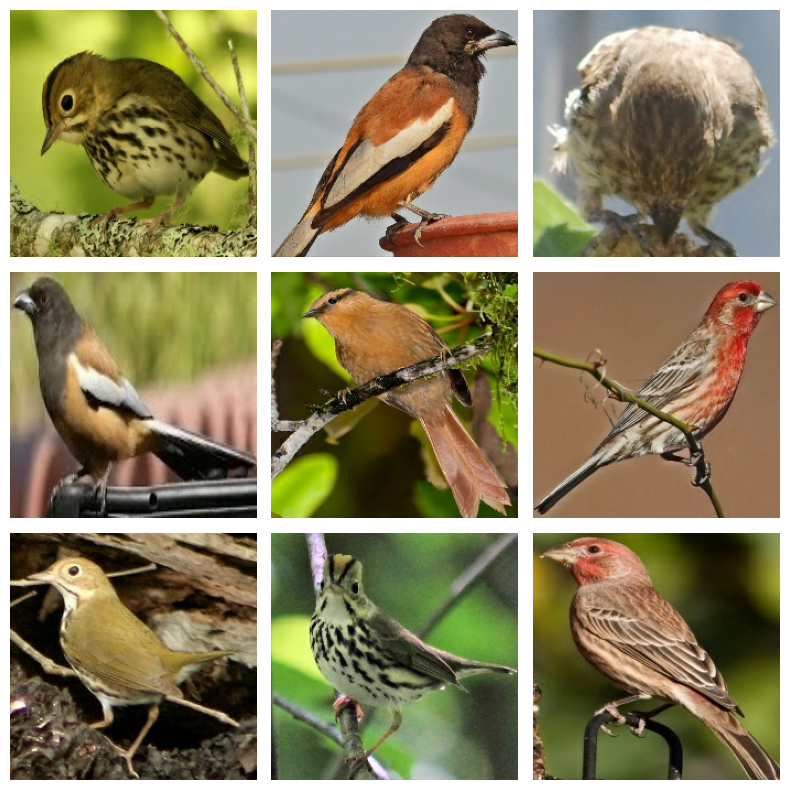

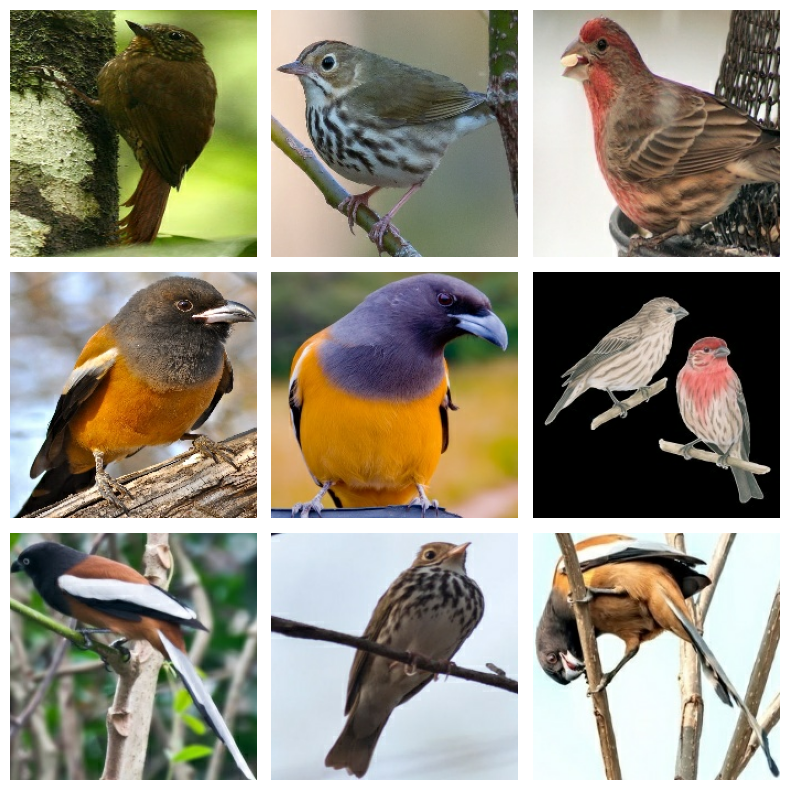

In [29]:
for images, labels in train_dataset.take(2):
    plt.figure(figsize=(8, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

In [31]:
import numpy as np

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)) # input_shape change to accomodate change in image size
conv_base.trainable = False

def get_features_and_labels(data_folder ):
    all_features = []
    all_labels = []
    for images, labels in data_folder :
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 14ms/step


In [32]:
train_features.shape

(744, 7, 7, 512)

In [33]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [35]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [37]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=(validation_generator))

Epoch 1/20
24/24 [==============================] - 5s 194ms/step - loss: 0.5859 - accuracy: 0.9987 - val_loss: 0.4986 - val_accuracy: 1.0000
Epoch 2/20
24/24 [==============================] - 5s 201ms/step - loss: 0.8198 - accuracy: 0.9973 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - 5s 205ms/step - loss: 0.6374 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
24/24 [==============================] - 5s 194ms/step - loss: 0.4020 - accuracy: 0.9987 - val_loss: 4.1072 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 5s 193ms/step - loss: 0.4164 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 5s 193ms/step - loss: 0.6026 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - 5s 194ms/step - loss: 0.6081 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_acc

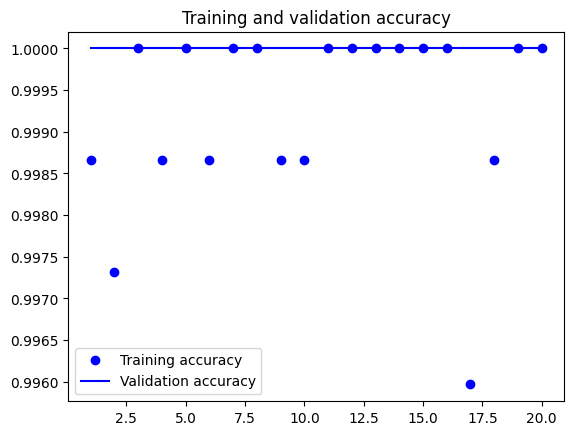

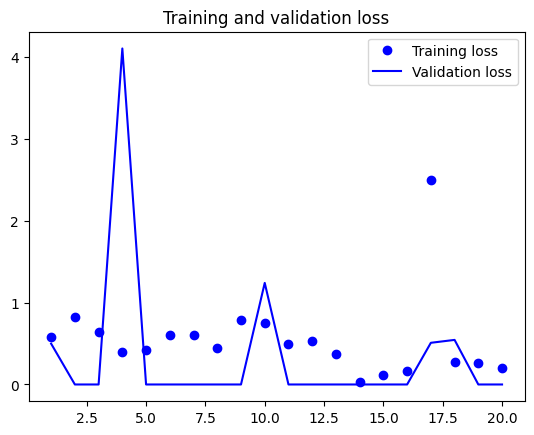

In [38]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [39]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [41]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


history1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=(validation_generator))

Epoch 1/20
24/24 [==============================] - 7s 250ms/step - loss: 0.6570 - accuracy: 0.9960 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
24/24 [==============================] - 6s 234ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - 6s 234ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
24/24 [==============================] - 6s 251ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 6s 234ms/step - loss: 0.2785 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 6s 231ms/step - loss: 0.1229 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - 6s 231ms/step - loss: 0.2136 - accuracy: 0.9987 - val_loss: 0.0000e+

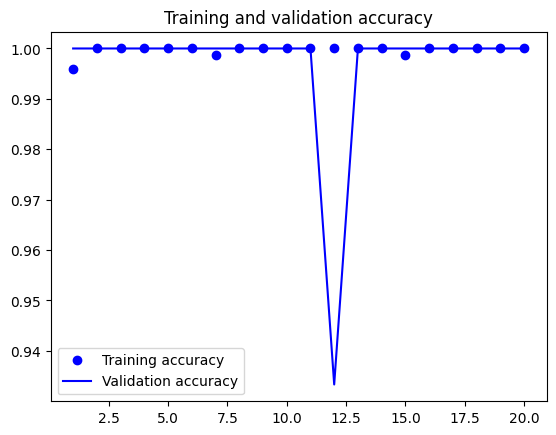

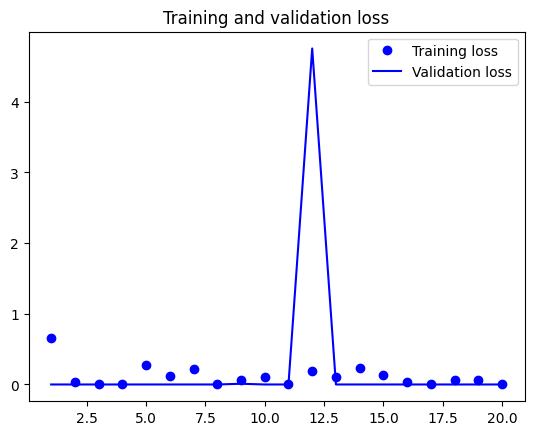

In [42]:
acc = history1.history["accuracy"]
val_acc = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [43]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 0s 145ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test accuracy: 1.000


In [46]:
def model_eval(model,test_data):
    # Make predictions
    predictions = model.predict(test_data) 
    # Convert predictions to class labels
    y_pred = np.argmax(predictions, axis=1)
    y_pred
    # True labels
    y_test = test_generator.classes
    y_test
    
    eval = {}
    eval['Accuracy'] = accuracy_score(y_test, y_pred)*100
    eval['Precision'] = precision_score(y_test, y_pred, average='weighted')*100
    eval['Recall'] = recall_score(y_test, y_pred, average='weighted')*100
    eval['f1 score'] = f1_score(y_test, y_pred, average='weighted')*100
    for k,v in eval.items():
        print(f"{k}\t{v:.2f}")
    return y_test,y_pred
model_eval(model,test_generator)

1/1 [==============================] - 0s 34ms/step
Accuracy	53.33
Precision	53.33
Recall	53.33
f1 score	53.33


(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32),
 array([0, 0, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 2, 0, 1]))